In [29]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.dates as mdates
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill
from datetime import datetime
import os

In [30]:
# Prepare Train Data for Preprocessing
df_check = pd.read_excel('check_data_to_students.xlsx')
df_train = pd.read_excel("train_data.xlsx")
df_validation = pd.read_excel("validation_data.xlsx")

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date', inplace=True)

power_columns = [f"Power{i}" for i in range(1, 97)]    # Define the list of power columns (assumes columns are named "Power1", "Power2", ..., "Power96")

In [31]:
# Define Helper Functions
def find_missing_sequences(missing_bool):
    sequences = []
    start = None
    
    for i, val in enumerate(missing_bool):
        if val and start is None:
            start = i
        elif not val and start is not None:
            sequences.append((start, i-1))
            start = None
    
    if start is not None:
        sequences.append((start, len(missing_bool)-1))
    
    return sequences

def normalize_row(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    # Avoid division by zero if all values are identical.
    if max_val - min_val == 0:
        return arr
    return (arr - min_val) / (max_val - min_val)

def impute_row(row, power_columns):
    arr = row[power_columns].values.copy()
    missing_bool = pd.isnull(arr)
    sequences = find_missing_sequences(missing_bool)
    
    for start, end in sequences:
        seq_len = end - start + 1
        
        # Single missing value
        if seq_len == 1:
            if start > 0:
                arr[start] = arr[start-1]  # forward fill
            else:
                arr[start] = arr[end+1] if end+1 < len(arr) else np.nan
        
        # Small gaps (2-4 missing)
        elif 2 <= seq_len <= 4:
            left_idx = max(0, start-1)
            right_idx = min(len(arr)-1, end+1)
            left_val = arr[left_idx]
            right_val = arr[right_idx]
            
            # Linear interpolation
            for i in range(seq_len):
                arr[start+i] = left_val + (right_val-left_val)*(i+1)/(seq_len+1)
        
        # Larger gaps (5-38 missing)
        else:
            left_idx = max(0, start-1)
            right_idx = min(len(arr)-1, end+1)
            left_val = arr[left_idx]
            right_val = arr[right_idx]
            
            # Linear interpolation for larger gaps
            for i in range(seq_len):
                arr[start+i] = left_val + (right_val-left_val)*(i+1)/(seq_len+1)
    
    return arr

def time_series_impute(df, method='linear', max_total_threshold=38, power_columns=power_columns):
    df_imputed = df.copy()
    
    # Convert index to datetime if needed
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'timestamp' in df.columns:
            df_imputed = df_imputed.set_index('timestamp')
        elif 'date' in df.columns:
            df_imputed = df_imputed.set_index('date')
        df_imputed.index = pd.to_datetime(df_imputed.index)
    
    # Sort by time
    df_imputed = df_imputed.sort_index()
    
    # Apply selected imputation method to remaining missing values
    if method == 'linear':
        df_imputed = df_imputed.interpolate(method='linear')
    elif method == 'ffill':
        df_imputed = df_imputed.ffill()
    elif method == 'spline':
        df_imputed = df_imputed.interpolate(method='spline', order=3)
    elif method == 'seasonal':
        if df_imputed.index.hour.nunique() > 1:
            df_imputed = df_imputed.groupby(df_imputed.index.hour).transform(
                lambda x: x.interpolate(method='linear'))
        else:
            df_imputed = df_imputed.interpolate(method='linear')
    
    # Final processing statistics
    remaining_missing = df_imputed.isnull().sum().sum()
    if remaining_missing > 0:
        print(f"Note: {remaining_missing} missing values remain after processing")
    
    return df_imputed

In [32]:
# Helper Plotting Functions

# Function to Plot Data Over Daily Period
def plot_daily_load_data(df, day_date, power_columns, freq='15min', 
                        marker_size=2, color='blue', figsize=(15, 5)):
    # Input validation
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    
    try:
        day_date = pd.to_datetime(day_date)
        next_day = day_date + pd.Timedelta(days=1)
    except:
        raise ValueError("day_date must be in 'YYYY-MM-DD' format")
    
    # Filter data for the day
    try:
        df_day = df.loc[day_date:next_day].copy()
        if len(df_day) == 0:
            raise ValueError("No data found for the specified day")
    except Exception as e:
        available_dates = f"{df.index[0].date()} to {df.index[-1].date()}"
        raise ValueError(f"Date not available. Data exists from {available_dates}") from e
    
    # Process data
    flattened_data = df_day[power_columns].values.flatten()
    time_axis = pd.date_range(
        start=df_day.index[0], 
        periods=len(flattened_data), 
        freq=freq
    )
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(
        time_axis, 
        flattened_data, 
        marker='o', 
        linestyle='-', 
        markersize=marker_size, 
        color=color,
        alpha=0.7
    )
    
    # Formatting
    plt.title(f'Daily Load Data for {day_date.date()}')
    plt.xlabel('Time of Day')
    plt.ylabel('Load (kW)')
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    
    # Add time period shading
    ax = plt.gca()
    
    # Morning (6AM-9AM)
    ax.axvspan(
        day_date.replace(hour=6), 
        day_date.replace(hour=9), 
        color='green', 
        alpha=0.05,
        label='Morning'
    )
    
    # Evening (6PM-9PM)
    ax.axvspan(
        day_date.replace(hour=18), 
        day_date.replace(hour=21), 
        color='orange', 
        alpha=0.05,
        label='Evening'
    )
    
    # Night (10PM-5AM)
    ax.axvspan(
        day_date.replace(hour=22), 
        day_date.replace(hour=5), 
        color='gray', 
        alpha=0.1,
        label='Night'
    )
    
    # Add hour markers
    for hour in range(0, 24):
        ax.axvline(
            day_date.replace(hour=hour),
            color='red' if hour in [0, 12, 18] else 'yellow',
            alpha=0.1,
            linestyle='--',
            linewidth=1
        )
    
    # Format x-axis to show hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return df_day

# Function to Plot Data Over Weekly Period
def plot_weekly_load_data(df, start_date, power_columns, freq='15min', 
                         marker_size=2, color='blue', figsize=(15, 5)):
    # Input validation
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    
    try:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(days=7)
    except:
        raise ValueError("start_date must be in 'YYYY-MM-DD' format")
    
    # Filter data for the week
    try:
        df_week = df.loc[start_date:end_date].copy()
        if len(df_week) == 0:
            raise ValueError("No data found for the specified week")
    except Exception as e:
        available_dates = f"{df.index[0].date()} to {df.index[-1].date()}"
        raise ValueError(f"Date range not available. Data exists from {available_dates}") from e
    
    # Process data
    flattened_data = df_week[power_columns].values.flatten()
    time_axis = pd.date_range(
        start=df_week.index[0], 
        periods=len(flattened_data), 
        freq=freq
    )
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(
        time_axis, 
        flattened_data, 
        marker='o', 
        linestyle='-', 
        markersize=marker_size, 
        color=color,
        alpha=0.7
    )
    
    # Formatting
    plt.title(f'Weekly Load Data from {start_date.date()} to {end_date.date()}')
    plt.xlabel('Time')
    plt.ylabel('Load (kW)')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    
    # Add shaded nights and day markers
    ax = plt.gca()
    for day in pd.date_range(start_date, periods=7, freq='D'):
        # Night shading (10PM-6AM)
        ax.axvspan(
            day.replace(hour=22), 
            (day + pd.Timedelta(days=1)).replace(hour=6), 
            color='gray', 
            alpha=0.1
        )
        # Noon marker
        ax.axvline(
            day.replace(hour=12),
            color='yellow',
            alpha=0.2,
            linestyle='--',
            linewidth=1
        )
    
    # Format x-axis to show days clearly
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%H:%M'))
    plt.tight_layout()
    plt.show()
    
    return df_week

# Function to Plot Data Over Monthly Period
def plot_monthly_load_data(df, month_str, power_columns, freq='15min', 
                          marker_size=2, color='blue', figsize=(15, 5)):
    # Input validation
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")
    
    if month_str not in df.index.strftime('%Y-%m').unique():
        available_months = df.index.strftime('%Y-%m').unique()
        raise ValueError(f"Month not found. Available months: {available_months}")
    
    # Filter and process data
    try:
        df_month = df.loc[month_str].sort_index()
        flattened_data = df_month[power_columns].values.flatten()
        
        # Generate time axis
        start_date = df_month.index[0]
        time_axis = pd.date_range(
            start=start_date, 
            periods=len(flattened_data), 
            freq=freq
        )
        
        # Plotting
        plt.figure(figsize=figsize)
        plt.plot(
            time_axis, 
            flattened_data, 
            marker='o', 
            linestyle='-', 
            markersize=marker_size, 
            color=color,
            alpha=0.7
        )
        
        # Formatting
        plt.title(f'Continuous {freq} Load Data for {month_str}')
        plt.xlabel('Time')
        plt.ylabel('Load (kW)')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        
        # Add shaded nights
        if isinstance(time_axis[0], pd.Timestamp):
            ax = plt.gca()
            for day in pd.date_range(start_date, periods=31, freq='D'):
                if day.month == start_date.month:  # Only shade for selected month
                    ax.axvspan(
                        day.replace(hour=0), 
                        day.replace(hour=6), 
                        color='gray', 
                        alpha=0.1
                    )
        
        plt.tight_layout()
        plt.show()
        
        return df_month
    
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None

# Function to Plot Data Over Seasonal Period
def plot_seasonal_load_data(df, season_year, season_name, power_columns, freq='15min', 
                           compare_years=False, year_range=None, figsize=(18, 8)):
    # Validate season input
    valid_seasons = ['winter', 'spring', 'summer', 'autumn']
    if season_name.lower() not in valid_seasons:
        raise ValueError(f"Invalid season. Must be one of: {valid_seasons}")
    
    # Define seasonal date ranges
    season_ranges = {
        'winter': ('12-21', '03-20'),  # Dec 21 - Mar 20
        'spring': ('03-21', '06-20'),  # Mar 21 - Jun 20
        'summer': ('06-21', '09-20'),  # Jun 21 - Sep 20
        'autumn': ('09-21', '12-20')  # Sep 21 - Dec 20
    }
    
    # Prepare plot
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    seasonal_data = {}
    
    # Determine years to analyze
    years_to_compare = [season_year]
    if compare_years and year_range:
        years_to_compare.extend(range(year_range[0], year_range[1]))
        years_to_compare = sorted(list(set(years_to_compare)))  # Remove duplicates
    
    for year in years_to_compare:
        # Construct date range
        start_date = pd.to_datetime(f"{year}-{season_ranges[season_name][0]}")
        end_date = pd.to_datetime(f"{year}-{season_ranges[season_name][1]}")
        
        # Handle winter spanning year change
        if season_name == 'winter':
            end_date = pd.to_datetime(f"{year+1}-{season_ranges[season_name][1]}")
        
        # Filter data
        df_season = df.loc[start_date:end_date].copy()
        
        if len(df_season) == 0:
            print(f"No data found for {season_name} {year}")
            continue
        
        # Resample to daily averages for cleaner visualization
        df_daily = df_season[power_columns].resample('D').mean()
        
        # Plot seasonal trend
        for col in power_columns:
            label = f"{year} {col}" if compare_years else col
            ax.plot(df_daily.index, df_daily[col], 
                    label=label,
                    alpha=0.8 if compare_years else 1,
                    linewidth=2 if year == season_year else 1.5)
        
        seasonal_data[year] = df_season
    
    # Formatting
    plt.title(f"{season_name.capitalize()} Load Patterns ({season_year}" + 
              (f" vs {year_range[0]}-{year_range[1]-1}" if compare_years else "") + ")")
    plt.xlabel('Date')
    plt.ylabel('Average Daily Load (kW)')
    
    # Add seasonal markers
    if season_name == 'summer':
        ax.axvspan(pd.to_datetime(f"{season_year}-07-01"), 
                  pd.to_datetime(f"{season_year}-08-31"), 
                  color='yellow', alpha=0.05, label='Peak Summer')
    elif season_name == 'winter':
        ax.axvspan(pd.to_datetime(f"{season_year}-12-25"), 
                  pd.to_datetime(f"{season_year+1 if season_name=='winter' else season_year}-01-05"), 
                  color='blue', alpha=0.05, label='Holiday Period')
    
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return seasonal_data if compare_years else df_season

In [33]:
# Prepare Train Data for Preprocessing
df_check = pd.read_excel('check_data_to_students.xlsx')
df_train = pd.read_excel("train_data.xlsx")
df_validation = pd.read_excel("validation_data.xlsx")

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date', inplace=True)

power_columns = [f"Power{i}" for i in range(1, 97)]    # Define the list of power columns (assumes columns are named "Power1", "Power2", ..., "Power96")

In [34]:
# Determine Quantity and Location of Missing Values
processed_rows = []
invalid_days_info = {}

# Process each day (row) in the dataset to populate invalid_days_info
for day, row in df_train.iterrows():
    # Extract the 96 power measurements as a NumPy array
    arr = row[power_columns].values
    # Create a boolean array indicating where values are missing
    missing_bool = pd.isnull(arr)
    # Identify consecutive missing sequences
    sequences = find_missing_sequences(missing_bool)
    # Total missing count for the day
    total_missing = int(missing_bool.sum())
    # Store lengths of each missing sequence
    sequences_lengths = [end - start + 1 for (start, end) in sequences] if sequences else []
    
    # If there are any missing values, store the information
    if total_missing > 0:
        invalid_days_info[day] = {
            'total_missing': total_missing,
            'sequences': sequences_lengths,
            'missing_positions': np.where(missing_bool)[0].tolist()  # Adding positions of missing values
        }
    else:
        # If no missing values, add the row to processed rows as-is
        processed_rows.append(row.copy())

# Print details of invalid days.
if invalid_days_info:
    print("Invalid days with missing measurements:")
    for day, info in invalid_days_info.items():
        date_str = day.strftime('%Y-%m-%d')
        total = info['total_missing']
        seqs_str = ", ".join(str(length) for length in info['sequences'])
        print(f"{date_str}: Total missing: {total}, Consecutive sequences: [{seqs_str}]")
else:
    print("No invalid days found.")

Invalid days with missing measurements:
2022-01-02: Total missing: 63, Consecutive sequences: [63]
2022-02-05: Total missing: 8, Consecutive sequences: [8]
2022-04-07: Total missing: 8, Consecutive sequences: [1, 1, 3, 1, 2]
2022-04-08: Total missing: 1, Consecutive sequences: [1]
2022-04-09: Total missing: 28, Consecutive sequences: [28]
2022-04-11: Total missing: 58, Consecutive sequences: [58]
2022-04-13: Total missing: 1, Consecutive sequences: [1]
2022-04-20: Total missing: 1, Consecutive sequences: [1]
2022-04-21: Total missing: 1, Consecutive sequences: [1]
2022-04-22: Total missing: 48, Consecutive sequences: [2, 46]
2022-05-05: Total missing: 23, Consecutive sequences: [3, 9, 2, 1, 1, 1, 6]
2022-05-12: Total missing: 2, Consecutive sequences: [2]
2022-05-16: Total missing: 1, Consecutive sequences: [1]
2022-06-01: Total missing: 1, Consecutive sequences: [1]
2022-06-07: Total missing: 4, Consecutive sequences: [4]
2022-06-08: Total missing: 1, Consecutive sequences: [1]
2022-0

In [35]:
# First Pass to Handle Missing Values
removed_info = {}
processed_rows = []
threshold = 38

for idx, row in df_train.iterrows():
    missing_count = row[power_columns].isnull().sum()
    
    # Strict removal condition
    if missing_count > threshold:
        removed_info[idx] = {
            'missing_count': missing_count,
            'missing_positions': np.where(row[power_columns].isnull())[0].tolist(),
            'original_data': row[power_columns].values.tolist()
        }
        continue  # Skip this row entirely
    
    # Only process rows that meet the threshold
    if missing_count > 0:
        imputed_values = impute_row(row, power_columns)
        row[power_columns] = imputed_values
    
    processed_rows.append(row)

# Create the processed DataFrame
processed_df = pd.DataFrame(processed_rows)

# Print summary
print(f"Total missing values remaining: {processed_df[power_columns].isnull().sum().sum()}")

processed_df.index = processed_df.index.strftime('%Y-%m-%d')

# Save the preprocessed valid data to a new Excel file.
output_filename = 'preprocessed_data_1.xlsx'
processed_df.to_excel(output_filename, index_label='Date')

print(f"Preprocessed data written to {output_filename}")

Total missing values remaining: 90
Preprocessed data written to preprocessed_data_1.xlsx


In [36]:
# Second Pass to Handle Missing Values
df_train_2 = pd.read_excel("preprocessed_data_1.xlsx")

# Set the date column as index
df_train_2 = df_train_2.set_index('Date')
df_train_2.index = pd.to_datetime(df_train_2.index)

# Can use different method to adjust how the missing values are filled
processed_df_2 = time_series_impute(df=df_train_2, method='linear', max_total_threshold=38, power_columns=power_columns)

# Print summary
print(f"Total missing values remaining: {processed_df_2[power_columns].isnull().sum().sum()}")

processed_df_2.index = processed_df_2.index.strftime('%Y-%m-%d')

# Save the preprocessed valid data to a new Excel file.
output_filename_2 = 'preprocessed_data_2.xlsx'
processed_df_2.to_excel(output_filename_2, index_label='Date')

print(f"Preprocessed data written to {output_filename_2}")

Total missing values remaining: 0
Preprocessed data written to preprocessed_data_2.xlsx


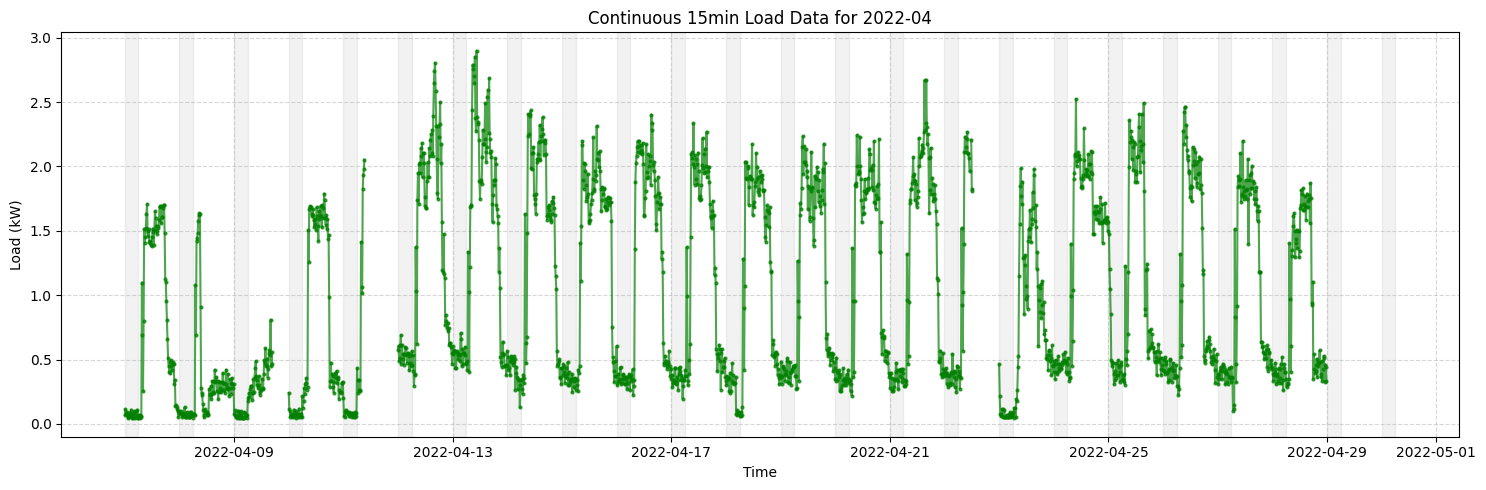

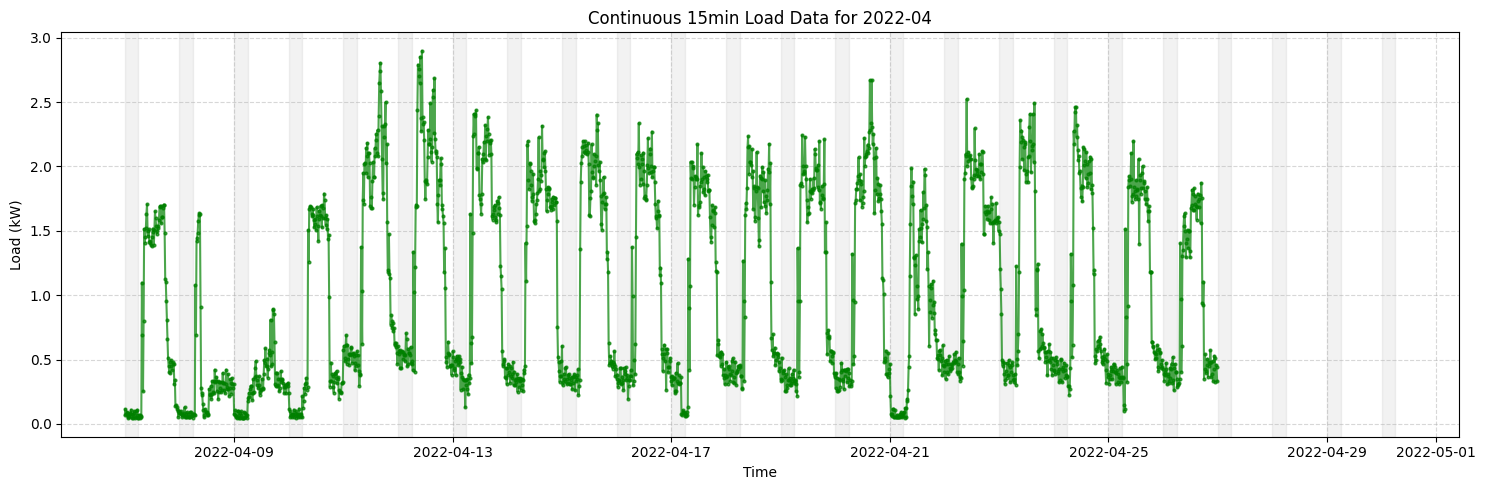

In [37]:
# Before and After Data Changes
df_train_clean = pd.read_excel('preprocessed_data_2.xlsx')

df_train_clean['Date'] = pd.to_datetime(df_train_clean['Date'])
df_train_clean.set_index('Date', inplace=True)

selected_month = '2022-04'                             # Change this string to a different month if needed.
df_month = df_train_clean.loc[selected_month]
df_month = df_month.sort_index()                       # Ensure the data for the selected month is sorted by date.

monthly = plot_monthly_load_data(df=df_train, month_str=selected_month, power_columns=power_columns, freq='15min', color='green')
imputed = plot_monthly_load_data(df=df_month, month_str=selected_month, power_columns=power_columns, freq='15min', color='green')

In [93]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# -----------------------------------------
# Model 1: Holiday-Aware Anomaly Flagger
# -----------------------------------------

def flag_holiday_anomalies(anomaly_file, holiday_file, output_file):
    # Load anomalies (timestamps at 15-min intervals)
    df_anom = pd.read_excel(anomaly_file)
    df_anom['timestamp'] = pd.to_datetime(df_anom['timestamp'])
    df_anom['date'] = df_anom['timestamp'].dt.date

    # Load holiday calendar and normalize column name
    df_hol = pd.read_excel(holiday_file)
    # Rename 'Date' (capital D) to 'date'
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    holidays = set(df_hol['date'])

    # Flag anomalies occurring on holidays
    df_anom['Holiday_Anomaly'] = df_anom['date'].apply(lambda d: d in holidays)

    # Save updated anomalies
    df_anom.to_excel(output_file, index=False)
    print(f"Holiday-flagged anomalies saved to {output_file}")


# -----------------------------------------
# Model 2: High-Accuracy Anomaly Classifier
# -----------------------------------------

def train_anomaly_model(data_file, flagged_anomaly_file, holiday_file, model_output):
    # Load main time-series data (rows=daily, cols=Power1..Power96)
    df = pd.read_excel(data_file)
    # Ensure the date column is named 'date'
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    # Load flagged anomalies from Model 1
    df_anom = pd.read_excel(flagged_anomaly_file)
    df_anom['timestamp'] = pd.to_datetime(df_anom['timestamp'])
    df_anom['date'] = df_anom['timestamp'].dt.date
    df_anom['time_slot'] = df_anom['timestamp'].dt.hour * 4 + df_anom['timestamp'].dt.minute // 15 + 1
    # Keep only non-holiday anomalies for training
    df_non_hol = df_anom[df_anom['Holiday_Anomaly'] == False]
    anom_set = set(zip(df_non_hol['date'], df_non_hol['time_slot']))

    # Build flattened dataset with one row per 15-min interval
    records = []
    for _, day in df.iterrows():
        d = day['date']
        for slot in range(1, 97):
            value = day.get(f'Power{slot}', np.nan)
            label = int((d, slot) in anom_set)
            records.append({'date': d,
                            'time_slot': slot,
                            'value': value,
                            'label': label})
    df_flat = pd.DataFrame(records)

    # Feature engineering
    df_flat['day_of_week'] = pd.to_datetime(df_flat['date']).dt.weekday
    df_flat['is_weekend'] = df_flat['day_of_week'].isin([5, 6]).astype(int)

    # Holiday indicator
    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    holiday_set = set(df_hol['date'])
    df_flat['is_holiday'] = df_flat['date'].apply(lambda d: d in holiday_set).astype(int)

    # Compute mean value per slot on non-holiday data
    slot_means = df_flat[df_flat['is_holiday'] == 0].groupby('time_slot')['value'].mean()
    df_flat['diff_from_slot_mean'] = df_flat.apply(lambda row: row['value'] - slot_means.loc[row['time_slot']], axis=1)

    # Prepare features and labels
    feature_cols = ['value', 'time_slot', 'day_of_week', 'is_weekend', 'is_holiday', 'diff_from_slot_mean']
    X = df_flat[feature_cols]
    y = df_flat['label']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Initialize XGBoost classifier
    clf = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        scale_pos_weight=(len(y_train) - y_train.sum()) / max(y_train.sum(), 1),
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Train the model
    clf.fit(X_train, y_train)

    # Evaluation
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Save the trained model
    joblib.dump(clf, model_output)
    print(f"Model saved to {model_output}")


# ------------------------------
# Execution example
# ------------------------------
if __name__ == '__main__':
    anomaly_input = 'anomalies_mstl.xlsx'
    holiday_cal = 'China_Holiday_Calendar_2022_2024.xlsx'
    flagged_output = 'anomalies_flagged.xlsx'

    # Model 1: Flag holiday anomalies
    flag_holiday_anomalies(anomaly_input, holiday_cal, flagged_output)

    # Model 2: Train anomaly classifier
    data_input = 'preprocessed_data_2.xlsx'
    model_file = 'anomaly_model.xgb'
    train_anomaly_model(data_input, flagged_output, holiday_cal, model_file)


Holiday-flagged anomalies saved to anomalies_flagged.xlsx
Classification Report:
              precision    recall  f1-score   support

           0     0.9869    0.8628    0.9207     12890
           1     0.1475    0.6740    0.2421       454

    accuracy                         0.8564     13344
   macro avg     0.5672    0.7684    0.5814     13344
weighted avg     0.9583    0.8564    0.8976     13344

Confusion Matrix:
[[11122  1768]
 [  148   306]]
Model saved to anomaly_model.xgb


c:\Users\ibrahim\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:58:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# -----------------------------------------
# Model 2: High-Accuracy Anomaly Classifier
# -----------------------------------------

def train_anomaly_model(data_file, flagged_anomaly_file, holiday_file, model_output):
    # Load main time-series data (daily rows, Power1..Power96 columns)
    df = pd.read_excel(data_file)
    # Ensure the date column is 'date'
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    # Load flagged anomalies (from Model 1)
    df_anom = pd.read_excel(flagged_anomaly_file)
    df_anom['timestamp'] = pd.to_datetime(df_anom['timestamp'])
    df_anom['date'] = df_anom['timestamp'].dt.date
    # Compute time-slot index (1 to 96)
    df_anom['time_slot'] = df_anom['timestamp'].dt.hour * 4 + df_anom['timestamp'].dt.minute // 15 + 1
    # Filter out holiday anomalies
    df_non_hol = df_anom[df_anom['Holiday_Anomaly'] == False]
    anom_set = set(zip(df_non_hol['date'], df_non_hol['time_slot']))

    # Flatten data: one record per 15-min interval
    records = []
    for _, day in df.iterrows():
        d = day['date']
        for slot in range(1, 97):
            val = day.get(f'Power{slot}', np.nan)
            label = int((d, slot) in anom_set)
            records.append({'date': d,
                            'time_slot': slot,
                            'value': val,
                            'label': label})
    df_flat = pd.DataFrame(records)

    # Feature engineering
    df_flat['day_of_week'] = pd.to_datetime(df_flat['date']).dt.weekday
    df_flat['is_weekend'] = df_flat['day_of_week'].isin([5, 6]).astype(int)

    # Holiday indicator
    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    holiday_set = set(df_hol['date'])
    df_flat['is_holiday'] = df_flat['date'].apply(lambda d: d in holiday_set).astype(int)

    # Deviation from mean per slot (excluding holidays)
    slot_means = df_flat[df_flat['is_holiday'] == 0].groupby('time_slot')['value'].mean()
    df_flat['diff_from_slot_mean'] = df_flat.apply(
        lambda row: row['value'] - slot_means.loc[row['time_slot']], axis=1
    )

    # Prepare training data
    feature_cols = ['value', 'time_slot', 'day_of_week', 'is_weekend', 'is_holiday', 'diff_from_slot_mean']
    X = df_flat[feature_cols]
    y = df_flat['label']

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Initialize and train XGBoost classifier
    clf = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        scale_pos_weight=(len(y_train) - y_train.sum()) / max(y_train.sum(), 1),
        use_label_encoder=False,
        eval_metric='logloss'
    )
    clf.fit(X_train, y_train)

    # Evaluate model
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Save trained model
    joblib.dump(clf, model_output)
    print(f"Model saved to {model_output}")


# ------------------------------
# Execution example for Model 2
# ------------------------------
if __name__ == '__main__':
    data_input = 'preprocessed_data_2.xlsx'
    flagged_anomalies = 'anomalies_flagged.xlsx'
    holiday_calendar = 'China_Holiday_Calendar_2022_2024.xlsx'
    output_model = 'anomaly_model.xgb'

    train_anomaly_model(data_input, flagged_anomalies, holiday_calendar, output_model)


Classification Report:
              precision    recall  f1-score   support

           0     0.9869    0.8628    0.9207     12890
           1     0.1475    0.6740    0.2421       454

    accuracy                         0.8564     13344
   macro avg     0.5672    0.7684    0.5814     13344
weighted avg     0.9583    0.8564    0.8976     13344

Confusion Matrix:
[[11122  1768]
 [  148   306]]
Model saved to anomaly_model.xgb


c:\Users\ibrahim\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:59:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# -----------------------------------------
# Model 1: Holiday-Aware Anomaly Flagger
# -----------------------------------------

def flag_holiday_anomalies(anomaly_file, holiday_file, output_file):
    df_anom = pd.read_excel(anomaly_file)
    df_anom['timestamp'] = pd.to_datetime(df_anom['timestamp'])
    df_anom['date'] = df_anom['timestamp'].dt.date

    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    holidays = set(df_hol['date'])

    df_anom['Holiday_Anomaly'] = df_anom['date'].apply(lambda d: d in holidays)
    df_anom.to_excel(output_file, index=False)
    print(f"Holiday-flagged anomalies saved to {output_file}")


# -----------------------------------------
# Model 2: High-Accuracy Anomaly Classifier
# -----------------------------------------

def train_anomaly_model(data_file, flagged_anomaly_file, holiday_file):
    # Load and prepare training data
    df = pd.read_excel(data_file)
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    df_anom = pd.read_excel(flagged_anomaly_file)
    df_anom['timestamp'] = pd.to_datetime(df_anom['timestamp'])
    df_anom['date'] = df_anom['timestamp'].dt.date
    df_anom['time_slot'] = df_anom['timestamp'].dt.hour * 4 + df_anom['timestamp'].dt.minute // 15 + 1
    df_non_hol = df_anom[df_anom['Holiday_Anomaly'] == False]
    anom_set = set(zip(df_non_hol['date'], df_non_hol['time_slot']))

    records = []
    for _, day in df.iterrows():
        d = day['date']
        for slot in range(1, 97):
            val = day.get(f'Power{slot}', np.nan)
            label = int((d, slot) in anom_set)
            records.append({'date': d,
                            'time_slot': slot,
                            'value': val,
                            'label': label})
    df_flat = pd.DataFrame(records)
    df_flat['day_of_week'] = pd.to_datetime(df_flat['date']).dt.weekday
    df_flat['is_weekend'] = df_flat['day_of_week'].isin([5, 6]).astype(int)

    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    holiday_set = set(df_hol['date'])
    df_flat['is_holiday'] = df_flat['date'].apply(lambda d: d in holiday_set).astype(int)

    slot_means = df_flat[df_flat['is_holiday'] == 0].groupby('time_slot')['value'].mean()
    df_flat['diff_from_slot_mean'] = df_flat.apply(
        lambda row: row['value'] - slot_means.loc[row['time_slot']], axis=1
    )

    features = ['value', 'time_slot', 'day_of_week', 'is_weekend', 'is_holiday', 'diff_from_slot_mean']
    X = df_flat[features]
    y = df_flat['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        scale_pos_weight=(len(y_train) - y_train.sum()) / max(y_train.sum(), 1),
        use_label_encoder=False,
        eval_metric='logloss'
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return clf, slot_means


def predict_for_year(model, slot_means, holiday_file, year_data_file, output_file):
    # Load 2024 data
    df_year = pd.read_excel(year_data_file)
    if 'Date' in df_year.columns:
        df_year.rename(columns={'Date': 'date'}, inplace=True)
    df_year['date'] = pd.to_datetime(df_year['date']).dt.date

    records = []
    for _, day in df_year.iterrows():
        d = day['date']
        for slot in range(1, 97):
            val = day.get(f'Power{slot}', np.nan)
            records.append({'date': d,
                            'time_slot': slot,
                            'value': val})
    df_flat = pd.DataFrame(records)

    # Features
    df_flat['day_of_week'] = pd.to_datetime(df_flat['date']).dt.weekday
    df_flat['is_weekend'] = df_flat['day_of_week'].isin([5, 6]).astype(int)

    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    holiday_set = set(df_hol['date'])
    df_flat['is_holiday'] = df_flat['date'].apply(lambda d: d in holiday_set).astype(int)

    df_flat['diff_from_slot_mean'] = df_flat.apply(
        lambda row: row['value'] - slot_means.loc[row['time_slot']], axis=1
    )

    feature_cols = ['value', 'time_slot', 'day_of_week', 'is_weekend', 'is_holiday', 'diff_from_slot_mean']
    X_year = df_flat[feature_cols]

    # Predict
    df_flat['anomaly_prob'] = model.predict_proba(X_year)[:, 1]
    df_flat['anomaly_label'] = model.predict(X_year)

    # Save predictions
    df_flat.to_excel(output_file, index=False)
    print(f"Predictions for 2024 saved to {output_file}")


# ------------------------------
# Execution example
# ------------------------------
if __name__ == '__main__':
    anomaly_input = 'anomalies_mstl.xlsx'
    holiday_cal = 'China_Holiday_Calendar_2022_2024.xlsx'
    flagged_output = 'anomalies_flagged.xlsx'
    preprocessed = 'preprocessed_data_2.xlsx'
    year_data = 'validation_data.xlsx'  # data for year 2024
    prediction_output = 'anomalies_2024_predictions.xlsx'

    # Model 1
    flag_holiday_anomalies(anomaly_input, holiday_cal, flagged_output)
    # Model 2 Training
    model, slot_means = train_anomaly_model(preprocessed, flagged_output, holiday_cal)
    # Predict for 2024
    predict_for_year(model, slot_means, holiday_cal, year_data, prediction_output)

    # Optionally save the model
    joblib.dump(model, 'anomaly_model.xgb')


In [96]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import joblib

# -----------------------------------------
# Power Forecasting Model
# -----------------------------------------

def load_holidays(holiday_file):
    df_hol = pd.read_excel(holiday_file)
    # Normalize date column
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    return set(df_hol['date'])


def prepare_flat_data(data_file, holiday_file=None, for_training=True):
    """
    Flatten daily data into 15-min interval records with features.
    If for_training=True, includes the target 'value'.
    """
    df = pd.read_excel(data_file)
    # Normalize date column
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    # Load holiday dates if provided
    holidays = load_holidays(holiday_file) if holiday_file else set()

    records = []
    for _, day in df.iterrows():
        d = day['date']
        dow = datetime.combine(d, datetime.min.time()).weekday()
        is_weekend = int(dow >= 5)
        is_holiday = int(d in holidays)
        for slot in range(1, 97):
            val = day.get(f'Power{slot}', np.nan)
            rec = {
                'time_slot': slot,
                'day_of_week': dow,
                'is_weekend': is_weekend,
                'is_holiday': is_holiday
            }
            if for_training:
                rec['value'] = val
            records.append(rec)
    df_flat = pd.DataFrame(records)
    return df_flat


def train_power_model(train_file, holiday_file=None, model_output='power_model.xgb'):
    # Prepare training data
    df_flat = prepare_flat_data(train_file, holiday_file, for_training=True)
    X = df_flat[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y = df_flat['value']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize and train regressor
    reg = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        objective='reg:squarederror'
    )
    reg.fit(X_train, y_train)

    # Evaluate
    preds = reg.predict(X_test)
    rmse = np.sqrt(((preds - y_test)**2).mean())
    print(f"Test RMSE: {rmse:.4f}")

    # Save model
    joblib.dump(reg, model_output)
    print(f"Power model saved to {model_output}")
    return reg


def predict_power(model, holiday_file, year_file, output_file='power_2024_predictions.xlsx'):
    # Prepare features for 2024
    df_flat = prepare_flat_data(year_file, holiday_file, for_training=False)
    X_year = df_flat[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]

    # Predict
    df_flat['predicted_power'] = model.predict(X_year)

    # Pivot back to daily format
    df_out = df_flat.pivot_table(
        index=df_flat.index // 96,  # group every 96 rows per day
        columns='time_slot',
        values='predicted_power'
    )
    df_out.columns = [f'Power{col}' for col in df_out.columns]
    df_out.reset_index(drop=True, inplace=True)

    # Add date column
    df_dates = pd.read_excel(year_file)
    if 'Date' in df_dates.columns:
        df_dates.rename(columns={'Date': 'date'}, inplace=True)
    df_out.insert(0, 'date', pd.to_datetime(df_dates['date']).dt.date)

    # Save predictions
    df_out.to_excel(output_file, index=False)
    print(f"Power predictions saved to {output_file}")


# ------------------------------
# Execution example
# ------------------------------
if __name__ == '__main__':
    train_file = 'preprocessed_data_2.xlsx'
    holiday_file = 'China_Holiday_Calendar_2022_2024.xlsx'
    year_file = 'validation_data.xlsx'  # or your 2024 dates file

    # Train model
    model = train_power_model(train_file, holiday_file)

    # Predict 2024
    predict_power(model, holiday_file, year_file)


Test RMSE: 0.6564
Power model saved to power_model.xgb
Power predictions saved to power_2024_predictions.xlsx


In [102]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import joblib

# -----------------------------------------
# Power Forecasting and Evaluation Script
# -----------------------------------------

def load_holidays(holiday_file):
    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    return set(df_hol['date'])


def prepare_flat_data(data_file, holiday_file=None, for_training=True):
    """
    Flatten daily data into 15-min interval records with features.
    If for_training=True, includes the target 'value'.
    Returns DataFrame with columns: time_slot, day_of_week, is_weekend, is_holiday, [value].
    """
    df = pd.read_excel(data_file)
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    holidays = load_holidays(holiday_file) if holiday_file else set()
    records = []
    for _, day in df.iterrows():
        d = day['date']
        dow = d.weekday()
        is_weekend = int(dow >= 5)
        is_holiday = int(d in holidays)
        for slot in range(1, 97):
            rec = {
                'time_slot': slot,
                'day_of_week': dow,
                'is_weekend': is_weekend,
                'is_holiday': is_holiday
            }
            if for_training:
                rec['value'] = day.get(f'Power{slot}', np.nan)
            records.append(rec)
    return pd.DataFrame(records)


def train_power_model(train_file, holiday_file=None, model_output='power_model.xgb'):
    # Prepare training data
    df_train = prepare_flat_data(train_file, holiday_file, for_training=True)
    X = df_train[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y = df_train['value']

    # Split for evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train regressor
    reg = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        objective='reg:squarederror'
    )
    reg.fit(X_train, y_train)

    # Evaluate on test split
    preds = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
    print(f"Train/Test Performance:")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

    # Save model
    joblib.dump(reg, model_output)
    print(f"Power model saved to {model_output}")
    return reg


def predict_power(model, holiday_file, year_file, output_file='power_2024_predictions.xlsx'):
    # Prepare features for prediction (no 'value')
    df_pred = prepare_flat_data(year_file, holiday_file, for_training=False)
    X_year = df_pred[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]

    # Generate predictions
    df_pred['predicted_power'] = model.predict(X_year)

    # Pivot back to daily format
    n_days = len(df_pred) // 96
    df_out = pd.DataFrame({
        'date': pd.to_datetime(pd.read_excel(year_file)['Date']).dt.date
    })
    for slot in range(1, 97):
        df_out[f'Power{slot}'] = df_pred.loc[df_pred['time_slot'] == slot, 'predicted_power'].values

    df_out.to_excel(output_file, index=False)
    print(f"Power predictions saved to {output_file}")
    return df_out


def evaluate_model_performance(model, holiday_file, validation_file):
    # Prepare validation data with actual values
    df_val = prepare_flat_data(validation_file, holiday_file, for_training=True)
    X_val = df_val[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y_true = df_val['value']

    # Predict
    y_pred = model.predict(X_val)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print("Validation Performance on {}:".format(validation_file))
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}


# ------------------------------
# Execution example
# ------------------------------
if __name__ == '__main__':
    train_file = 'preprocessed_data_2.xlsx'
    holiday_file = 'China_Holiday_Calendar_2022_2024.xlsx'
    validation_file = 'validation_data.xlsx'

    # Train the model and evaluate on test split
    model = train_power_model(train_file, holiday_file)

    # Predict 2024 power values
    predict_power(model, holiday_file, validation_file)

    # Evaluate performance on 2024 validation set
    evaluate_model_performance(model, holiday_file, validation_file)


Train/Test Performance:
RMSE: 0.6564, MAE: 0.4778, MAPE: 190.29%
Power model saved to power_model.xgb
Power predictions saved to power_2024_predictions.xlsx


ValueError: Input contains NaN.

In [105]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import joblib

# -----------------------------------------
# Power Forecasting and Evaluation Script
# -----------------------------------------

def load_holidays(holiday_file):
    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    return set(df_hol['date'])


def prepare_flat_data(data_file, holiday_file=None, for_training=True):
    """
    Flatten daily data into 15-min interval records with features.
    If for_training=True, includes the target 'value'.
    """
    df = pd.read_excel(data_file)
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    holidays = load_holidays(holiday_file) if holiday_file else set()
    records = []
    for _, day in df.iterrows():
        d = day['date']
        dow = d.weekday()
        is_weekend = int(dow >= 5)
        is_holiday = int(d in holidays)
        for slot in range(1, 97):
            rec = {
                'time_slot': slot,
                'day_of_week': dow,
                'is_weekend': is_weekend,
                'is_holiday': is_holiday
            }
            if for_training:
                rec['value'] = day.get(f'Power{slot}', np.nan)
            records.append(rec)
    return pd.DataFrame(records)


def train_power_model(train_file, holiday_file=None, model_output='power_model.xgb'):
    # Prepare training data
    df_train = prepare_flat_data(train_file, holiday_file, for_training=True)
    # Drop rows with missing target
    df_train = df_train.dropna(subset=['value'])
    X = df_train[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y = df_train['value']

    # Split for evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train regressor
    reg = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        objective='reg:squarederror'
    )
    reg.fit(X_train, y_train)

    # Evaluate on test split
    preds_test = reg.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
    mae_test = mean_absolute_error(y_test, preds_test)
    mape_test = np.mean(np.abs((y_test - preds_test) / (y_test + 1e-3))) * 100
    print("Train/Test Performance:")
    print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, MAPE: {mape_test:.2f}%")

    # Save model
    joblib.dump(reg, model_output)
    print(f"Power model saved to {model_output}")
    return reg


def predict_power(model, holiday_file, year_file, output_file='power_2024_predictions.xlsx'):
    # Prepare features for prediction
    df_pred = prepare_flat_data(year_file, holiday_file, for_training=False)
    X_year = df_pred[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]

    # Generate predictions
    df_pred['predicted_power'] = model.predict(X_year)

    # Pivot back to daily format
    df_original = pd.read_excel(year_file)
    if 'Date' in df_original.columns:
        df_original.rename(columns={'Date': 'date'}, inplace=True)
    df_output = pd.DataFrame({ 'date': pd.to_datetime(df_original['date']).dt.date })
    for slot in range(1, 97):
        df_output[f'Power{slot}'] = df_pred.loc[df_pred['time_slot'] == slot, 'predicted_power'].values

    df_output.to_excel(output_file, index=False)
    print(f"Power predictions saved to {output_file}")
    return df_output


def evaluate_model_performance(model, holiday_file, validation_file):
    # Prepare validation data with actual values
    df_val = prepare_flat_data(validation_file, holiday_file, for_training=True)
    # Drop rows with missing actual power values
    df_val = df_val.dropna(subset=['value'])
    X_val = df_val[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y_true = df_val['value']

    # Predict
    y_pred = model.predict(X_val)

    # Compute overall metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-3))) * 100
    print(f"Validation Performance on {validation_file}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    # Detailed error analysis by time slot
    df_val['predicted'] = y_pred
    df_val['error'] = df_val['predicted'] - df_val['value']
    df_val['abs_pct_error'] = np.abs(df_val['error'] / (df_val['value'] + 1e-3))
    slot_stats = df_val.groupby('time_slot').agg({
        'error': ['mean', 'median'],
        'abs_pct_error': ['mean', 'median']
    })
    print("\nError statistics by time slot:")
    print(slot_stats)

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'slot_stats': slot_stats}


# ------------------------------
# Execution example
# ------------------------------
if __name__ == '__main__':
    train_file = 'preprocessed_data_2.xlsx'
    holiday_file = 'China_Holiday_Calendar_2022_2024.xlsx'
    validation_file = 'validation_data.xlsx'

    # Train the model and evaluate on test split
    model = train_power_model(train_file, holiday_file)

    # Predict 2024 power values
    predict_power(model, holiday_file, validation_file)

    # Evaluate performance on 2024 validation set
    evaluate_model_performance(model, holiday_file, validation_file)


Train/Test Performance:
RMSE: 0.6564, MAE: 0.4778, MAPE: 186.29%
Power model saved to power_model.xgb
Power predictions saved to power_2024_predictions.xlsx
Validation Performance on validation_data.xlsx:
RMSE: 0.9156
MAE: 0.7150
MAPE: inf%

Error statistics by time slot:
              error           abs_pct_error          
               mean    median          mean    median
time_slot                                            
1         -0.517013 -0.262804      1.318908  0.746419
2         -0.516958 -0.248097      1.257084  0.752887
3         -0.519157 -0.286947      1.306896  0.761236
4         -0.526046 -0.271272      1.248852  0.763777
5         -0.533011 -0.279700      1.284827  0.770288
...             ...       ...           ...       ...
92        -0.531176 -0.287048      1.266358  0.721827
93        -0.529604 -0.290442      1.216983  0.733151
94        -0.518737 -0.255328      1.298624  0.743869
95        -0.550586 -0.329176      1.247785  0.748242
96        -0.510855 -0.26

In [107]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import joblib

# -----------------------------------------
# Power Forecasting and Evaluation Script
# -----------------------------------------

def load_holidays(holiday_file):
    df_hol = pd.read_excel(holiday_file)
    if 'Date' in df_hol.columns:
        df_hol.rename(columns={'Date': 'date'}, inplace=True)
    df_hol['date'] = pd.to_datetime(df_hol['date']).dt.date
    return set(df_hol['date'])


def prepare_flat_data(data_file, holiday_file=None, for_training=True):
    """
    Flatten daily data into 15-min interval records with features.
    If for_training=True, includes the target 'value'.
    """
    df = pd.read_excel(data_file)
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date

    holidays = load_holidays(holiday_file) if holiday_file else set()
    records = []
    for _, day in df.iterrows():
        d = day['date']
        dow = d.weekday()
        is_weekend = int(dow >= 5)
        is_holiday = int(d in holidays)
        for slot in range(1, 97):
            rec = {
                'time_slot': slot,
                'day_of_week': dow,
                'is_weekend': is_weekend,
                'is_holiday': is_holiday
            }
            if for_training:
                rec['value'] = day.get(f'Power{slot}', np.nan)
            records.append(rec)
    return pd.DataFrame(records)


def train_power_model(train_file, holiday_file=None, model_output='power_model.xgb'):
    # Prepare training data
    df_train = prepare_flat_data(train_file, holiday_file, for_training=True)
    df_train = df_train.dropna(subset=['value'])
    X = df_train[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y = df_train['value']

    # Split for evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train regressor
    reg = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        objective='reg:squarederror'
    )
    reg.fit(X_train, y_train)

    # Evaluate on test split
    preds_test = reg.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
    mae_test = mean_absolute_error(y_test, preds_test)
    # SMAPE for test split
    num_test = np.abs(preds_test - y_test)
    den_test = (np.abs(preds_test) + np.abs(y_test)) / 2 + 1e-6
    smape_test = np.mean(num_test / den_test) * 100
    # MAPE excluding near-zero true values
    mask_test = y_test > 0.1
    mape_nz_test = np.mean(np.abs((y_test[mask_test] - preds_test[mask_test]) / y_test[mask_test])) * 100
    print("Train/Test Performance:")
    print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")
    print(f"SMAPE: {smape_test:.2f}%, MAPE (y>0.1): {mape_nz_test:.2f}%")

    # Save model
    joblib.dump(reg, model_output)
    print(f"Power model saved to {model_output}")
    return reg


def predict_power(model, holiday_file, year_file, output_file='power_2024_predictions.xlsx'):
    # Prepare features for prediction
    df_pred = prepare_flat_data(year_file, holiday_file, for_training=False)
    X_year = df_pred[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]

    # Generate predictions
    df_pred['predicted_power'] = model.predict(X_year)

    # Pivot back to daily format
    df_original = pd.read_excel(year_file)
    if 'Date' in df_original.columns:
        df_original.rename(columns={'Date': 'date'}, inplace=True)
    df_output = pd.DataFrame({ 'date': pd.to_datetime(df_original['date']).dt.date })
    for slot in range(1, 97):
        df_output[f'Power{slot}'] = df_pred.loc[df_pred['time_slot'] == slot, 'predicted_power'].values

    df_output.to_excel(output_file, index=False)
    print(f"Power predictions saved to {output_file}")
    return df_output


def evaluate_model_performance(model, holiday_file, validation_file):
    # Prepare validation data with actual values
    df_val = prepare_flat_data(validation_file, holiday_file, for_training=True)
    df_val = df_val.dropna(subset=['value'])
    X_val = df_val[['time_slot', 'day_of_week', 'is_weekend', 'is_holiday']]
    y_true = df_val['value']

    # Predict
    y_pred = model.predict(X_val)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # SMAPE for validation
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_pred) + np.abs(y_true)) / 2 + 1e-6
    smape = np.mean(num / den) * 100
    # MAPE excluding near-zero true values
    mask = y_true > 0.1
    mape_nz = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    print(f"Validation Performance on {validation_file}:")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"SMAPE: {smape:.2f}%, MAPE (y>0.1): {mape_nz:.2f}%")

    # Systematic bias correction
    bias = np.mean(y_pred - y_true)
    y_corr = y_pred - bias
    rmse_bias = np.sqrt(mean_squared_error(y_true, y_corr))
    print(f"Bias (mean error): {bias:.4f}, Bias-corrected RMSE: {rmse_bias:.4f}")

    # Detailed error analysis by time slot
    df_val['predicted'] = y_pred
    df_val['error'] = df_val['predicted'] - df_val['value']
    df_val['abs_pct_error'] = np.abs(df_val['error'] / (df_val['value'] + 1e-3))
    slot_stats = df_val.groupby('time_slot').agg({
        'error': ['mean', 'median'],
        'abs_pct_error': ['mean', 'median']
    })
    print("\nError statistics by time slot:")
    print(slot_stats)
    return {'RMSE': rmse, 'MAE': mae, 'SMAPE': smape, 'MAPE_nz': mape_nz, 'Bias': bias, 'Bias_RMSE': rmse_bias, 'slot_stats': slot_stats}


# ------------------------------
# Execution example
# ------------------------------
if __name__ == '__main__':
    train_file = 'preprocessed_data_2.xlsx'
    holiday_file = 'China_Holiday_Calendar_2022_2024.xlsx'
    validation_file = 'validation_data.xlsx'

    # Train the model
    model = train_power_model(train_file, holiday_file)

    # Predict 2024 power values
    predict_power(model, holiday_file, validation_file)

    # Evaluate performance on 2024 validation set
    evaluate_model_performance(model, holiday_file, validation_file)


Train/Test Performance:
RMSE: 0.6564, MAE: 0.4778
SMAPE: 72.74%, MAPE (y>0.1): 73.66%
Power model saved to power_model.xgb
Power predictions saved to power_2024_predictions.xlsx
Validation Performance on validation_data.xlsx:
RMSE: 0.9156, MAE: 0.7150
SMAPE: 90.52%, MAPE (y>0.1): 77.70%
Bias (mean error): -0.1470, Bias-corrected RMSE: 0.9037

Error statistics by time slot:
              error           abs_pct_error          
               mean    median          mean    median
time_slot                                            
1         -0.517013 -0.262804      1.318908  0.746419
2         -0.516958 -0.248097      1.257084  0.752887
3         -0.519157 -0.286947      1.306896  0.761236
4         -0.526046 -0.271272      1.248852  0.763777
5         -0.533011 -0.279700      1.284827  0.770288
...             ...       ...           ...       ...
92        -0.531176 -0.287048      1.266358  0.721827
93        -0.529604 -0.290442      1.216983  0.733151
94        -0.518737 -0.255328 

In [108]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import joblib

def load_holidays(path):
    df = pd.read_excel(path)
    if 'Date' in df.columns:
        df.rename(columns={'Date':'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date']).dt.date
    return set(df['date'])

def prepare_flat(df, holidays):
    records = []
    for _, row in df.iterrows():
        d = row['date']
        dow = d.weekday()
        is_wknd = int(dow>=5)
        is_hol  = int(d in holidays)
        for slot in range(1,97):
            records.append({
                'time_slot':    slot,
                'day_of_week':  dow,
                'is_weekend':   is_wknd,
                'is_holiday':   is_hol,
                'value':        row.get(f'Power{slot}', np.nan)
            })
    return pd.DataFrame(records)

if __name__ == '__main__':
    # File paths
    train_fp      = 'preprocessed_data_2.xlsx'
    hol_fp        = 'China_Holiday_Calendar_2022_2024.xlsx'
    year2024_fp   = 'validation_data.xlsx'
    out_fp        = 'power_2024_predictions.xlsx'

    # Load & prepare training data
    df_train = pd.read_excel(train_fp)
    df_train.rename(columns={'Date':'date'}, inplace=True)
    df_train['date'] = pd.to_datetime(df_train['date']).dt.date
    holidays = load_holidays(hol_fp)
    df_flat  = prepare_flat(df_train, holidays).dropna(subset=['value'])

    # Train/test split & model
    X = df_flat[['time_slot','day_of_week','is_weekend','is_holiday']]
    y = df_flat['value']
    Xtr, Xte, ytr, yte = train_test_split(X,y,test_size=0.2,random_state=42)
    model = XGBRegressor(n_estimators=200, max_depth=6, objective='reg:squarederror')
    model.fit(Xtr, ytr)
    joblib.dump(model, 'power_model.xgb')
    print("Model trained and saved as power_model.xgb")

    # Load 2024 data & forecast
    df2024 = pd.read_excel(year2024_fp)
    df2024.rename(columns={'Date':'date'}, inplace=True)
    df2024['date'] = pd.to_datetime(df2024['date']).dt.date
    flat24 = prepare_flat(df2024, holidays)
    X24    = flat24[['time_slot','day_of_week','is_weekend','is_holiday']]
    flat24['predicted'] = model.predict(X24)

    # Pivot back to daily
    daily = pd.DataFrame({'date': df2024['date']})
    for s in range(1,97):
        daily[f'Power{s}'] = flat24.loc[flat24['time_slot']==s, 'predicted'].values
    daily.to_excel(out_fp, index=False)
    print(f"2024 predictions written to {out_fp}")


Model trained and saved as power_model.xgb
2024 predictions written to power_2024_predictions.xlsx


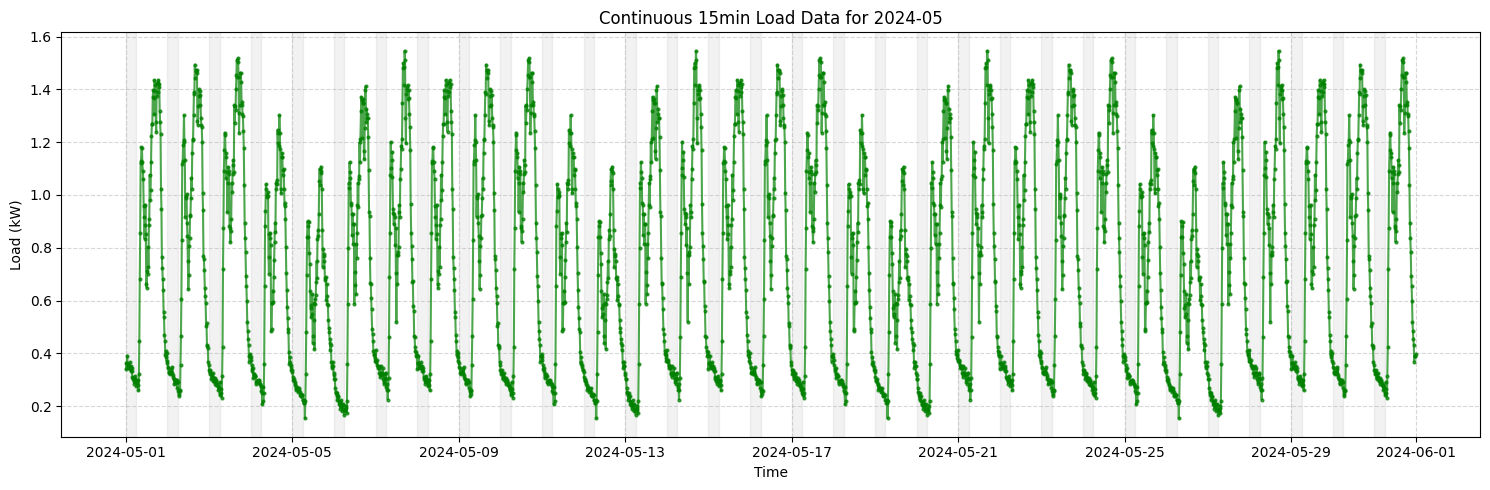

In [109]:
df_predict = pd.read_excel('power_2024_predictions.xlsx')

df_predict['date'] = pd.to_datetime(df_predict['date'])
df_predict.set_index('date', inplace=True)

selected_month = '2024-05'                             # Change this string to a different month if needed.
df_predict_month = df_predict.loc[selected_month]
df_predict_month = df_predict_month.sort_index()                       # Ensure the data for the selected month is sorted by date.

imputed = plot_monthly_load_data(df=df_predict_month, month_str=selected_month, power_columns=power_columns, freq='15min', color='green')